# Improving your model

At this point in the semester you've learned several models: linear regression, logistic regression, nearest neighbors and decision trees. Suppose you build a model and get your results. Is it possible to change your model in some way to improve the results? What can you try to accomplish? In this notebook we'll remind you of several techniques you have already learned, and introduce some new ones. We'll also work through an end-to-end example showing the data science lifecycle in action. 

## Imports

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

from scipy.stats import mode

## Loading data <a id="steps"></a>

For this project we'll be working with data on all commercial flights in January 2019. The data comes from a [Kaggle dataset](https://www.kaggle.com/divyansh22/flight-delay-prediction).

In [ ]:
df = pd.read_csv('data/flights_jan_2019.csv')

In [ ]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


## Data preparation

We'll start by only selecting the columns we want. Some columns are reduncant, as they give the airport both as a number and as an abbreviation. Some are not especially useful, like the tail number on the airplane. You can see a description of each column at the link to the dataset above. We have a description of the columns we are keeping below.

In [ ]:
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [ ]:
cols = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE']
df = df[cols]

Let's make the column names lowercase and do our usual check of missing values. We'll also rename the `op_carrier_airline_id` column to something simpler.

In [ ]:
cleaned_cols = [c.lower() if c != 'OP_CARRIER_AIRLINE_ID' else 'airline' for c in df.columns]
df.columns = cleaned_cols

for col in df.columns:
    missing_value_count = df[col].isna().sum()
    missing_value_pct = missing_value_count / df.shape[0]
    print(f'{col}: {missing_value_count} missing ({100*missing_value_pct:.2f}%)')

day_of_month: 0 missing (0.00%)
day_of_week: 0 missing (0.00%)
airline: 0 missing (0.00%)
origin: 0 missing (0.00%)
dest: 0 missing (0.00%)
dep_time: 16352 missing (2.80%)
dep_del15: 16355 missing (2.80%)
arr_time: 17061 missing (2.92%)
arr_del15: 18022 missing (3.09%)
cancelled: 0 missing (0.00%)
diverted: 0 missing (0.00%)
distance: 0 missing (0.00%)


Here is a brief description of the columns we are keeping (or at least the ones which aren't self-explanatory):
- **airline:** A unique identifier for the airline
- **origin:** The airport the plane started at
- **dest:** The airport the plane was headed to
- **dep_time:** The actual departure time, in the format "hhmm"
- **dep_del15:** Whether or not the flight departure was delayed by 15 minutes or more (0 = not delayed, 1 = delayed)
- **arr_time:** The actual arrival time, in the format "hhmm"
- **arr_del15:** Whether or not the flight arrival was delayed by 15 minutes or more
- **cancelled:** Whether or not the flight was cancelled (0 = not cancelled, 1 = cancelled)
- **diverted:** Whether or not the flight was diverted (told to change path, 0 = No, 1 = Yes)
- **distance:** The distance between the airports in miles

In this notebook we are interested in predicting whether or not a flight will be delayed upon arrival (will it arrive later than scheduled). Therefore, we will drop any rows which have missing values are the departure and arrival times/delays.

In [ ]:
df = df.dropna(how='any')

In [ ]:
print(f'{df.shape[0]} rows remaining')

565963 rows remaining


Let's check each column to make sure the data is what we expect it to be.

In [ ]:
df.dtypes

day_of_month      int64
day_of_week       int64
airline           int64
origin           object
dest             object
dep_time        float64
dep_del15       float64
arr_time        float64
arr_del15       float64
cancelled       float64
diverted        float64
distance        float64
dtype: object

These look good, except that the time columns (`dep_time` and `arr_time`) are of the form "hhmm", and we'd really like this to be simpler to work with. Let's just convert it to hours, so that "1200" becomes 12, and "1430" because 14.5 (since 30 minutes = 0.5 hours). Right now these are all stored as floats, which means getting the first two and last two digits is a bit tricky. What would be simpler is just to tell Pandas when loading this data that we want those columns to be strings. You can do this when running `read_csv()` by setting `dtype={'col_name': col_type}`. Rather than going through all this work again, we'll also tell Pandas to only load the subset of columns we want, using the `usecols=[first_col_number, second_col_number, ...]` parameter. You tell it which number column you want (they start at zero). Finally, we can specify `names=['col1_new_name', 'col2_new_name', ...]` to tell it what names we want to use.

In [ ]:
# Note that cols is the list of columns we want, which we defined earlier. cleaned_cols is the cleaned up column names we did earlier as well.
df = pd.read_csv(drive_dir + 'data/flights_jan_2019.csv', 
                 usecols=cols,
                 dtype={'DEP_TIME': str, 'ARR_TIME': str})

df.columns = cleaned_cols

df = df.dropna(how='any')

In [ ]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_time,dep_del15,arr_time,arr_del15,cancelled,diverted,distance
0,1,2,20363,GNV,ATL,0601,0.0,0722,0.0,0.0,0.0,300.0
1,1,2,20363,MSP,CVG,1359,0.0,1633,0.0,0.0,0.0,596.0
2,1,2,20363,DTW,CVG,1215,0.0,1329,0.0,0.0,0.0,229.0
3,1,2,20363,TLH,ATL,1521,0.0,1625,0.0,0.0,0.0,223.0
4,1,2,20363,ATL,FSM,1847,0.0,1940,0.0,0.0,0.0,579.0


That looks better. Let's now create the departure and arrival hour columns as described earlier. 

In [ ]:
def hhmm_to_hour(hhmm):
    # Get the first two characters
    hh = hhmm[:2]
    # Get the last two characters
    mm = hhmm[2:]
    # Turn them into integeres
    hh = int(hh)
    mm = int(mm)
    # Math
    hour = hh + mm/60
    return hour

In [ ]:
# Testing it out
hhmm_to_hour('1430')

14.5

In [ ]:
df['dep_hour'] = df['dep_time'].apply(hhmm_to_hour)
df['arr_hour'] = df['arr_time'].apply(hhmm_to_hour)

In [ ]:
df = df.drop(['dep_time', 'arr_time'], axis='columns')

In [ ]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
0,1,2,20363,GNV,ATL,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667
1,1,2,20363,MSP,CVG,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000
2,1,2,20363,DTW,CVG,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333
3,1,2,20363,TLH,ATL,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667
4,1,2,20363,ATL,FSM,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667


As mentioned above, we want to build a model to predict whether or not a flight will be delayed upon arrival. With that in mind, let's start exploring the data.

Finally, we'll need to work with numbers for our models, so let's label encode the origin and destination airports.

In [ ]:
origin_le = LabelEncoder()
df['origin'] = origin_le.fit_transform(df['origin'])

dest_le = LabelEncoder()
df['dest'] = dest_le.fit_transform(df['dest'])

In [ ]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
0,1,2,20363,128,19,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667
1,1,2,20363,225,80,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000
2,1,2,20363,95,80,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333
3,1,2,20363,325,19,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667
4,1,2,20363,19,120,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667


Finally, we will use this data again next week, so let's save a copy of the cleaned up version.

In [ ]:
df.to_csv('../data/flights_jan_2019_cleaned.csv', index=False)

## Data exploration

Since the goal is to understand flight delays, let's start by looking at the flights that are delayed. First, how many of them are there?

In [ ]:
df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

We only care about those that are delayed upon arrival, but let's also check out the departures.

In [ ]:
df['dep_del15'].value_counts(normalize=True)

0.0    0.826305
1.0    0.173695
Name: dep_del15, dtype: float64

Almost identical. How many flights have a delayed arrival but *not* a delayed departure (or vice-versa)?

In [ ]:
dep_del15_df = df[df['dep_del15'] == 1]
dep_del15_df['arr_del15'].value_counts(normalize=True)

1.0    0.796379
0.0    0.203621
Name: arr_del15, dtype: float64

So of those flights with a delayed departure, almost 80% of them also have a delayed arrival. Let's now do vice-versa.

In [ ]:
arr_del15_df = df[df['arr_del15'] == 1]
arr_del15_df['dep_del15'].value_counts(normalize=True)

1.0    0.744027
0.0    0.255973
Name: dep_del15, dtype: float64

Of those with a delayed arrival, about 74% of them had a delayed departure. So (not surprisingly) when predicting whether or not the arrival will be delayed, looking at whether or not the departure is delayed is highly relevant.

Next, we see that about 18.6% of flights have a delayed arrival. Let's go through each day of the month and see if one tends to have a much higher or lower rate than that. We'll do this using `groupby`. We'll add up the delayed arrivals for each day of the month using `.sum()`. Since `arr_del15` is either 0 or 1, adding it up will count how many delays there are. To get this as a percentage we'll divide by the `.count()` of how many flights arrived on that day of the month.

In [ ]:
df.groupby('day_of_month')['arr_del15'].sum() / df.groupby('day_of_month')['arr_del15'].count()

day_of_month
1     0.215423
2     0.257957
3     0.186185
4     0.127087
5     0.160788
6     0.198471
7     0.151579
8     0.101620
9     0.103387
10    0.143248
11    0.160589
12    0.150572
13    0.162158
14    0.151467
15    0.154934
16    0.129132
17    0.200223
18    0.219003
19    0.201091
20    0.210049
21    0.269010
22    0.225870
23    0.272890
24    0.311952
25    0.226672
26    0.133417
27    0.188134
28    0.178465
29    0.145864
30    0.204032
31    0.208535
Name: arr_del15, dtype: float64

It looks like there are a few days of the month with especially high/low delays, such as days 8 and 9 with only 10%, and day 24 with 31%. So maybe this column will be useful for our model. Let's do the same for `day_of_week`, `airline`, `origin` and `dest`.

In [ ]:
groupby_cols = ['day_of_week', 'airline', 'origin', 'dest']

for c in groupby_cols:
    print(df.groupby(c)['arr_del15'].sum() / df.groupby(c)['arr_del15'].count())
    print('='*40)

day_of_week
1    0.186837
2    0.167916
3    0.193716
4    0.209893
5    0.183462
6    0.160310
7    0.189246
Name: arr_del15, dtype: float64
airline
19393    0.150240
19690    0.125424
19790    0.128101
19805    0.182353
19930    0.173530
19977    0.198500
20304    0.227036
20363    0.202462
20366    0.247705
20368    0.258142
20378    0.185653
20397    0.155349
20398    0.246478
20409    0.274802
20416    0.158771
20436    0.248894
20452    0.238675
Name: arr_del15, dtype: float64
origin
0      0.202492
1      0.190476
2      0.128326
3      0.133333
4      0.084337
         ...   
341    0.131148
342    0.214286
343    0.200593
344    0.160000
345    0.078261
Name: arr_del15, Length: 346, dtype: float64
dest
0      0.197531
1      0.142857
2      0.144028
3      0.150000
4      0.120482
         ...   
341    0.171488
342    0.222222
343    0.176355
344    0.264151
345    0.139130
Name: arr_del15, Length: 346, dtype: float64


Once again, these all seem useful. There's certainly many more questions we could explore, but let's start building our model and see how it performs. Then, based on the results we can go back and try to answer some questions that our model doesn't seem to understand.

## Model building

As always we'll start by doing a train-test split. One thing which is good practice with imbalanced data is to split in a *stratified* way. By **stratified** we mean that the percentage of rows for the column you are trying to predict is approximately the same in the training and test sets. So for example, if 10% of the flights are delayed in the training set, then we also want approximately 10% of the flights to be delayed in the test set.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['arr_del15'])

In [ ]:
train_df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

In [ ]:
test_df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

You can see that both sets have 18.6% of the arrivals being delayed.

Let's split the data into X and y. Since some models can only use continuous values, we'll separate out the columns by type to make it easier to handle.

In [ ]:
y_col = 'arr_del15'

X_cont_cols = ['day_of_month', 'distance', 'dep_hour', 'arr_hour']
X_cat_cols = ['day_of_week', 'airline', 'origin', 'dest', 'cancelled', 'diverted', 'dep_del15']
X_all_cols = X_cont_cols + X_cat_cols

X_train_cont = train_df[X_cont_cols]
X_train_cat = train_df[X_cat_cols]
X_train_all = train_df[X_all_cols]

X_test_cont = test_df[X_cont_cols]
X_test_cat = test_df[X_cat_cols]
X_test_all = test_df[X_all_cols]

y_train = train_df[y_col]
y_test = test_df[y_col]

Let's now choose a model. Since we are doing classification our choices that we learned thus far are, along with a brief discussion of their strengths and weaknesses:
    - Logistic regression: Simple, basic linear regression in disguise. However, it only works with continuous columns.
    - Nearest neighbors: Very flexible, can work with both continuous and categorical columns. However, we want each flight to have a lot of "neighbors" to compare to. This may or may not be an issue.
    - Decision tree: Very flexible, can work with both continuous and categorical columns. The downside is that we need to be careful with picking the hyperparameters.
    
Logistic regression sounds like the weakest choice. However, it's good to start with a simple model and use the results as a baseline. Therefore, we'll train a logistic regression model using the continuous columns, and use the results as a baseline to try and beat.

### Logistic regression

In [ ]:
logr_clf = LogisticRegression()

logr_clf.fit(X_train_cont, y_train)

y_pred_logr = logr_clf.predict(X_test_cont)

In [ ]:
print(classification_report(y_test, y_pred_logr))

/Users/paulsavala/anaconda3/envs/math_3439/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90    184297
         1.0       0.00      0.00      0.00     42089

    accuracy                           0.81    226386
   macro avg       0.41      0.50      0.45    226386
weighted avg       0.66      0.81      0.73    226386



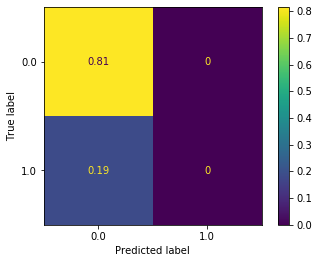

In [ ]:
plot_confusion_matrix(logr_clf, X_test_cont, y_test, normalize='all')

So logistic regression is never even predicting a flight to be delayed. Hopefully that won't be hard to beat...

### Nearest neighbors

Recall that nearest neighbors works by taking a single row and then finding $K$ other rows which are "closest" to it. By "closest" we mean the distance as measured using the `metric` hyperparameter. For continuous columns this could simply be the usual Euclidean distance function you're used to: $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$. But for categorical columns we want to use other metrics. Review last week's material if you are unsure of these.

If you just try to run nearest neighbors, you will see that it takes forever. The reason is that our dataset is quite large:

In [ ]:
print(f'{X_train_all.shape[0]} rows in the training data')

339577 rows in the training data


Therefore, we want to take a small sample and train on just that. One way to do that is to pick a small sample of the indices and just use those.

In [ ]:
sample_idx = np.random.choice(range(X_train_all.shape[0]), size=10000)

X_mini = X_train_all.iloc[sample_idx]
y_mini = y_train.iloc[sample_idx]

In [ ]:
nn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

nn_clf.fit(X_mini, y_mini)

y_pred_nn = nn_clf.predict(X_test_all)

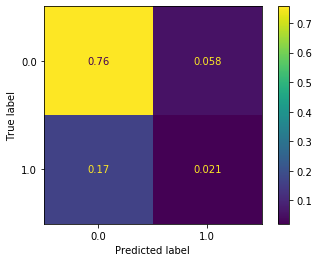

In [ ]:
plot_confusion_matrix(nn_clf, X_test_all, y_test, normalize='all')

This seems like an improvement, but there are still a number of issues:
1. There are a mixture of continuous and categorical variables. How we measure if distance is "close" is completely different from how we measure if two airlines are "close". Unfortunately, you can only specify one metric, so we have to pick one which is good at something and bad at something else.
2. It's slow to train. Nearest neighbors requires going through every point, then finding the five closest points, then seeing what they were predicted as. This takes lots of time.

Let's move on and try a decision tree.

### Decision trees

We'll fit a decision tree to all of the columns. We'll start with a guess at the hyperparameters and see how it turns out.

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=10)

dt_clf.fit(X_train_all, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

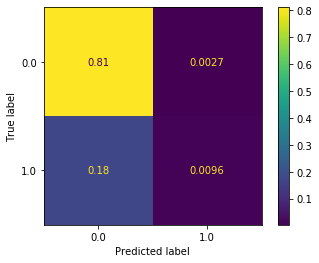

In [ ]:
plot_confusion_matrix(dt_clf, X_test_all, y_test, normalize='all')

This seems reasonable, but it's still underpredicting the delays (predicted label of 1). We saw previously that this can be partially addressed by resampling the data. We saw both over- and under-sampling the data performed well in this case. Since our dataset is large it seems reasonable to undersample. Remember that ovesampling means reusing sample from the minority class (flight delay) repeatedly in training. This is potentially problematic, and is primarily needed when your dataset is small.

In [ ]:
train_df['arr_del15'].value_counts()

0.0    276444
1.0     63133
Name: arr_del15, dtype: int64

In [ ]:
# Minority class has 63,133 samples
n_samples = 63133

train_delayed_df = train_df[train_df['arr_del15'] == 1]
train_not_delayed_df = train_df[train_df['arr_del15'] == 0].sample(n_samples)

train_under_df = pd.concat([train_delayed_df, train_not_delayed_df])

X_train_under = train_under_df[X_all_cols]
y_train_under = train_under_df[y_col]

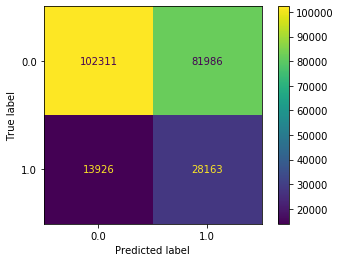

In [ ]:
dt_clf_under = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=10)

dt_clf_under.fit(X_train_under, y_train_under)

plot_confusion_matrix(dt_clf_under, X_test_all, y_test, values_format='d')

We now see that a label of 1 is being predicted far more often. In fact, it's being predicted a bit *too often* (as can be seen by 74,347 non-delayed flights being predicted as delayed). This isn't great, but at least our model is now predicting in a more balanced way.

## Cross validation and grid search <a id="cross_validation"></a>

Now that we have a model to start with we want to improve it. One major way to improve models is by finding which hyperparameters give the best results. We did this previously by picking some possibilities and simply writing `for` loops to try them all. This works, but it's problematic for a few reasons. One is that it's slow and kind of a pain. Another is that we have to keep re-using the test data over and over to see our results. Therefore, in essence we're training our model on the test data. That's not what test data is for. Test data is meant to be used only once you have a final (or near-final) model. The fix for this is cross validation.

**Cross validation** is a technique where you take your training data and split it into $n$ "folds". You then train your model on $n-1$ folds and evaluate it on the final fold. Here is an illustration of this from [sklearn's site](https://scikit-learn.org/stable/modules/cross_validation.html).

![Cross validation](images/grid_search_cross_validation.png)

Let's do an example by hand. Once we understand that we'll see how sklearn makes this easy for us. We'll take our training data and split it into five folds, as shown above. To do so we need to find how many rows there are and divide that by five.

In [ ]:
print(f'{train_under_df.shape[0]} rows, so each fold has {train_under_df.shape[0]/5} rows')

126266 rows, so each fold has 25253.2 rows


In [ ]:
fold1_df = train_under_df.iloc[:25253]
fold2_df = train_under_df.iloc[25253:2*25253]
fold3_df = train_under_df.iloc[2*25253:3*25253]
fold4_df = train_under_df.iloc[3*25253:4*25253]
fold5_df = train_under_df.iloc[4*25253:]

folds = [fold1_df, fold2_df, fold3_df, fold4_df, fold5_df]

In [ ]:
for i, f in enumerate(folds):
    print(f'Fold {i+1}: {f.shape[0]} rows')

Fold 1: 25253 rows
Fold 2: 25253 rows
Fold 3: 25253 rows
Fold 4: 25253 rows
Fold 5: 25254 rows


Now, we'll pick some hyperparameters, train our model on 4 of the folds, and then evaluate it on the final fold. This way, our test set is never used when we're finding hyperparameters!

In [ ]:
# Try increasing the max depth
dt_clf_under = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=10)

# Stack together the first four folds to train on
X_four_folds = pd.concat([fold1_df[X_all_cols], fold2_df[X_all_cols], fold3_df[X_all_cols], fold4_df[X_all_cols]])
y_four_folds = pd.concat([fold1_df[y_col], fold2_df[y_col], fold3_df[y_col], fold4_df[y_col]])

dt_clf_under.fit(X_four_folds, y_four_folds)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

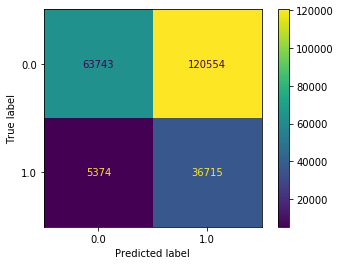

In [ ]:
# Evaluate it on the fifth fold
plot_confusion_matrix(dt_clf_under, X_test_all, y_test, values_format='d')

The goal of cross validation is to find good hyperparameters without having to re-use the test set over and over again for training. However, doing cross validation by hand like this is slow. Luckily, sklearn has a helper function called `GridSearchCV` which does two things: 
1. It performs cross validation as described above
2. It simultaneously goes through and tries a "grid" of hyperparameters that you specify.

Let's have it pick which hyperparameters are best out of the following options:

In [ ]:
hyperparam_grid = {'min_samples_split': [2, 5, 10, 15, 25, 50, 100],
                  'max_depth': [3, 5, 7, 10, 15, 25, 50],
                  'min_samples_leaf': [2, 5, 10, 15, 25, 50, 100]}

Next, we instantiate grid search just like you did for a model. However, to be clera, grid search is *not* a model, it's a way to pick the best hyperparameters for your model. What it does is return the model with the hyperparameters that gave the best result.

In [ ]:
dt_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_clf, hyperparam_grid, n_jobs=-1) # n_jobs tells it to use parallel processing. Long story short, it will be faster.

In [ ]:
# This may take a while, go grab a coffee...
grid_search.fit(X_train_under, y_train_under)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 25, 50],
            

Grid search can be slow. It is literally fitting a new model for all combinations of hyperparameters that you specified. So (for instance) if you specified five values of one parameter, ten of another, and 7 of one more, then it's fitting $5 \cdot 10\cdot 7=350$ models. So be careful to not just through tons and tons of hyperparameters at it, or it will never finish.

Once it's done, you can just use it exactly like your decision tree. In fact, it *is* your decision tree, with the best possible choice of hyperparameters from the possibilities you supplied. If you'd like to see exactly what those hyperparameters are, you can do the following:

In [ ]:
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 25, 'min_samples_split': 15}

So it looks like it got the best results with a max depth of 50 (much deeper than we tried!). Note that the max depth and min samples split are both the largest values I let it try. So maybe something larger would be better. Let's do another grid search, but pick parameters near what this grid search found was best.

In [ ]:
dt_clf = DecisionTreeClassifier()

hyperparam_grid = {'min_samples_split': [75, 100, 125, 150, 175, 200],
                  'max_depth': [75, 100, 125, 150, 175, 200],
                  'min_samples_leaf': [3, 5, 7]}

grid_search = GridSearchCV(dt_clf, hyperparam_grid, n_jobs=-1)

grid_search.fit(X_train_under, y_train_under)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [75, 100, 125, 150, 175, 200],
        

In [ ]:
grid_search.best_params_

{'max_depth': 175, 'min_samples_leaf': 5, 'min_samples_split': 200}

It looks like it keeps wanting to go deeper. For right now let's leave it at 200 and see how things go. We'll evaluate this model on our test set (which the decision tree hasn't yet seen!) and see what kind of results we get.

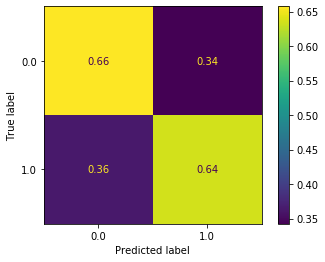

In [ ]:
plot_confusion_matrix(grid_search, X_test_all, y_test, normalize='true')

This is a big improvement. 65% of the non-delayed flights were predicted to be non-delayed, and 65% of the delayed flights were predicted to be delayed.

A good next step is to see where your model is struggling. What flights is it making an incorrect decision on? To do this we'll take the training data and make predictions. We'll then grab all rows where the prediction didn't match the actual delay.

In [ ]:
y_pred = grid_search.predict(X_train_all)

In [ ]:
misclassified_df = train_df[train_df['arr_del15'] != y_pred]

In [ ]:
misclassified_df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
561380,30,3,20366,156,149,0.0,0.0,0.0,0.0,295.0,16.600000,17.800000
176973,10,4,20304,306,297,0.0,1.0,0.0,0.0,599.0,8.533333,10.116667
132927,7,1,20378,251,14,0.0,0.0,0.0,0.0,602.0,19.683333,22.366667
514407,28,1,19805,251,327,0.0,0.0,0.0,0.0,1788.0,10.033333,15.900000
164421,9,3,20452,201,238,0.0,0.0,0.0,0.0,403.0,6.250000,7.916667


In [ ]:
print(f'{100*misclassified_df.shape[0] / train_df.shape[0]:.2f}% of training data was misclassified ({misclassified_df.shape[0]} samples)')

32.97% of training data was misclassified (111962 samples)


Let's also grab the training data which was classified *correctly* and see if any interesting differences jump out at us.

In [ ]:
correct_df = train_df[train_df['arr_del15'] == y_pred]
correct_df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
201091,11,5,19393,308,237,0.0,0.0,0.0,0.0,390.0,18.616667,19.916667
108973,6,7,20304,225,297,1.0,1.0,0.0,0.0,1589.0,23.383333,2.216667
1569,1,2,20409,246,148,0.0,0.0,0.0,0.0,1056.0,6.650000,9.550000
21341,2,3,19393,180,88,0.0,0.0,0.0,0.0,862.0,6.316667,9.850000
221442,12,6,19393,88,204,0.0,1.0,0.0,0.0,895.0,6.366667,10.233333


In [ ]:
# Compare the flight delays by day of month for the correctly and incorrectly classified samples
correct_df['day_of_month'].value_counts(normalize=True) - misclassified_df['day_of_month'].value_counts(normalize=True)

1    -0.011443
2    -0.009328
3    -0.007460
4     0.005143
5     0.007942
6     0.001150
7     0.003607
8     0.018945
9     0.021020
10    0.013903
11    0.009410
12    0.006477
13    0.000868
14    0.014917
15    0.008328
16    0.012050
17   -0.010234
18   -0.014203
19   -0.008355
20   -0.010037
21   -0.012790
22   -0.010344
23   -0.007255
24   -0.011964
25   -0.012326
26    0.008029
27   -0.000070
28    0.000288
29   -0.000477
30    0.002296
31   -0.008086
Name: day_of_month, dtype: float64

So no particular day of the month jumps out as being very different between the correctly and misclassified samples. Let's write a function to do this and plot it, and then do it for each column. We'll compute the percentage that it is off by, relative to the correct classification.

In [ ]:
def compare_classifications_by_col(col):
    comparison = correct_df[col].value_counts(normalize=True) - misclassified_df[col].value_counts(normalize=True)
    comparison = comparison / correct_df[col].value_counts(normalize=True)
    plt.figure(figsize=(12, 8))
    plt.plot(comparison)
    plt.title(f'Column {col}')

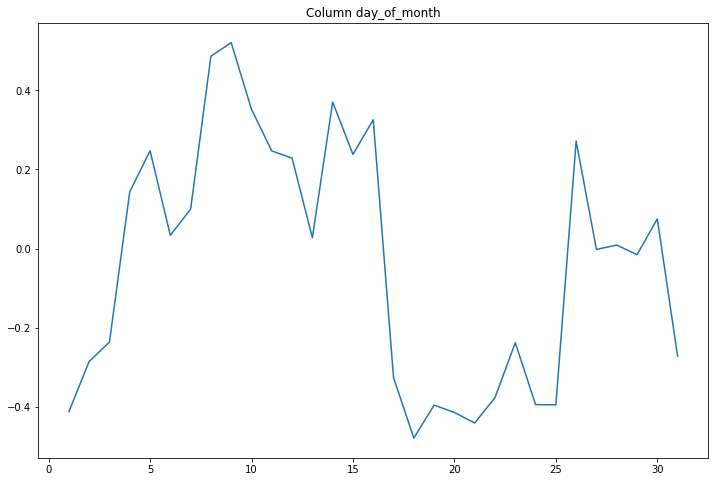

In [ ]:
compare_classifications_by_col('day_of_month')

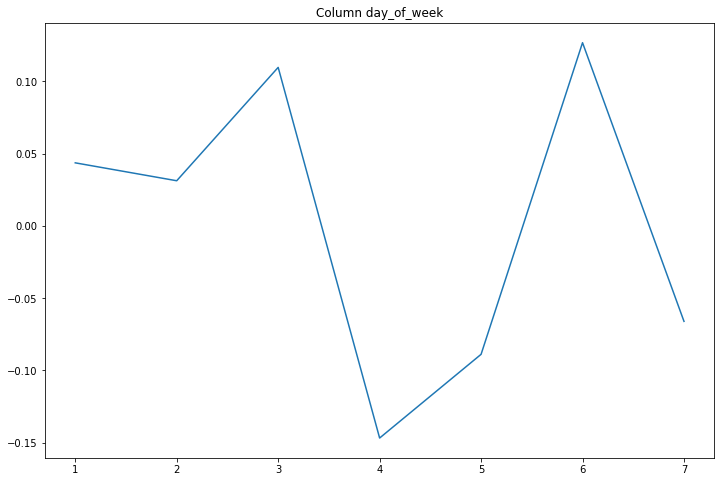

In [ ]:
compare_classifications_by_col('day_of_week')

A maximum relative difference of 10% based on the day of the week.

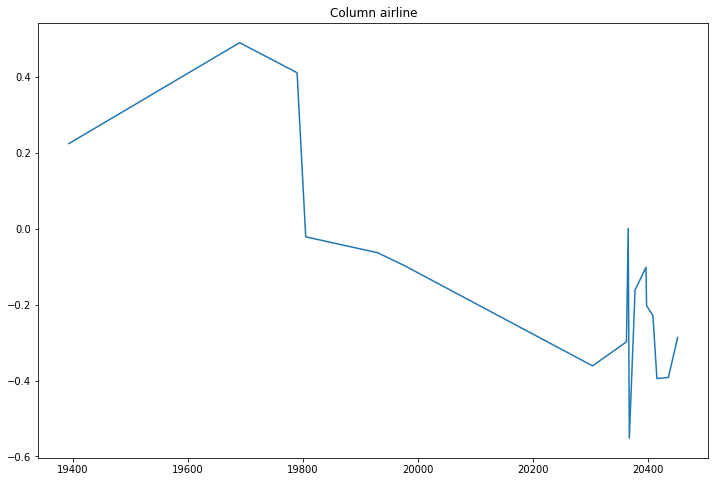

In [ ]:
compare_classifications_by_col('airline')

Certain airlines seem to do much worse than others.

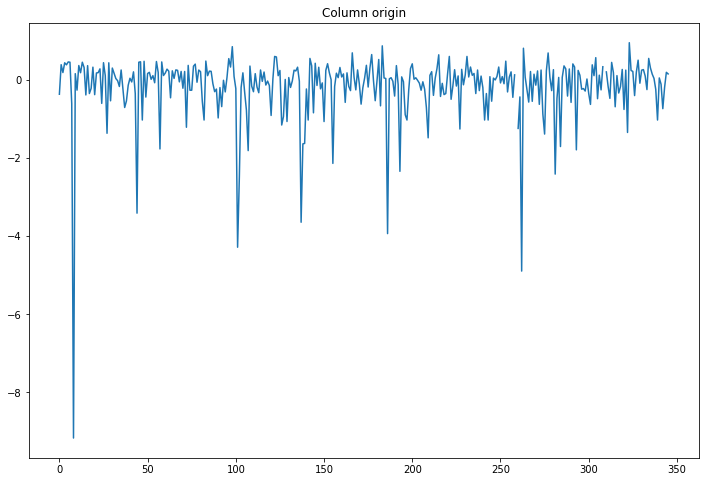

In [ ]:
compare_classifications_by_col('origin')

A big difference (relative to the others) for one airport, maybe we should look into that one.

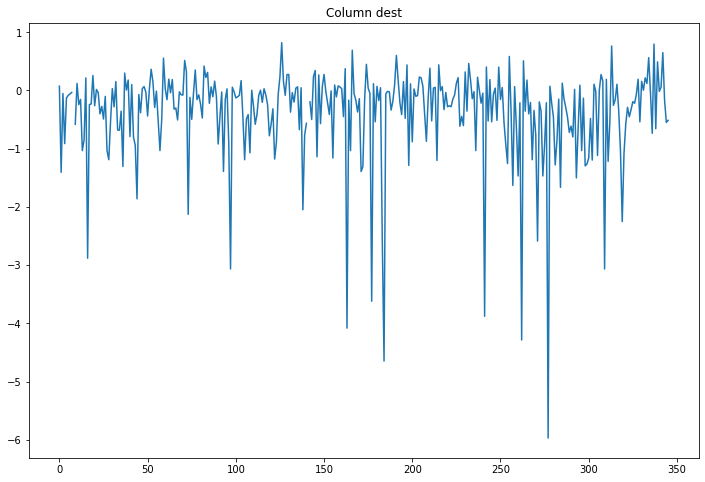

In [ ]:
compare_classifications_by_col('dest')

Same.

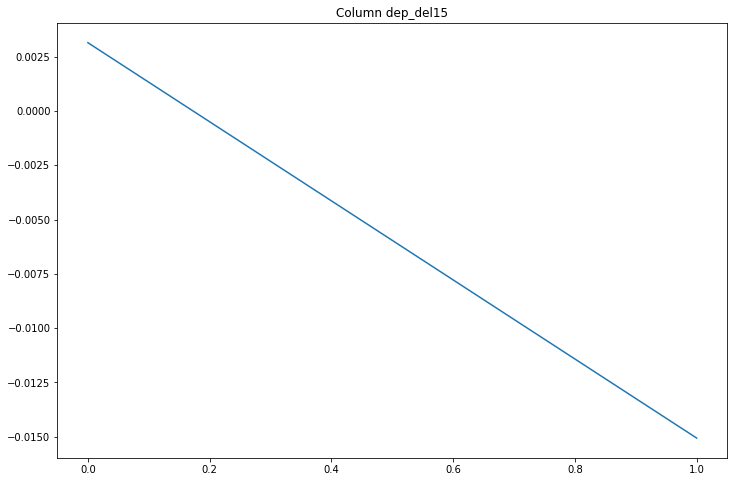

In [ ]:
compare_classifications_by_col('dep_del15')

Only a 0.8% difference, not interesting.

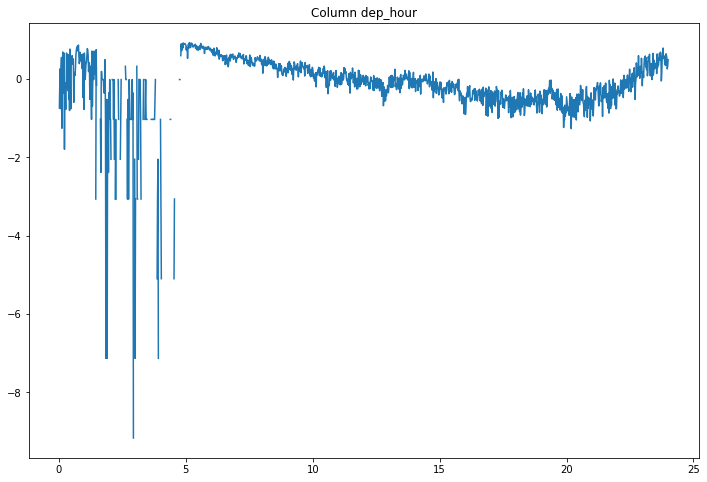

In [ ]:
compare_classifications_by_col('dep_hour')

Flights leaving early in the morning are often misclassified.

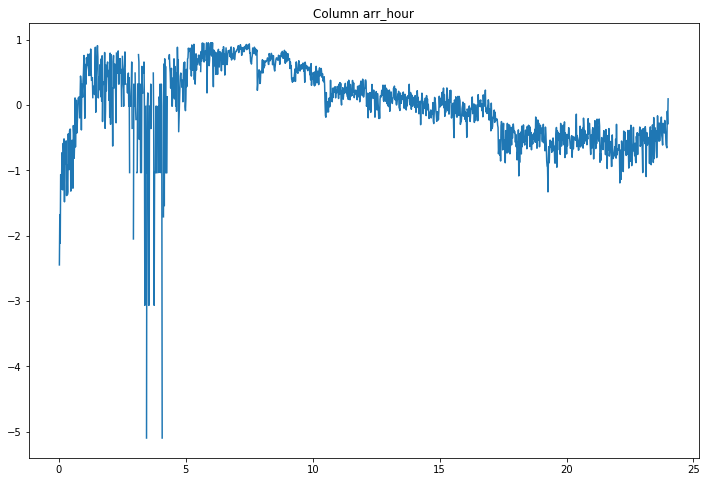

In [ ]:
compare_classifications_by_col('arr_hour')

Nothing big jumps out.

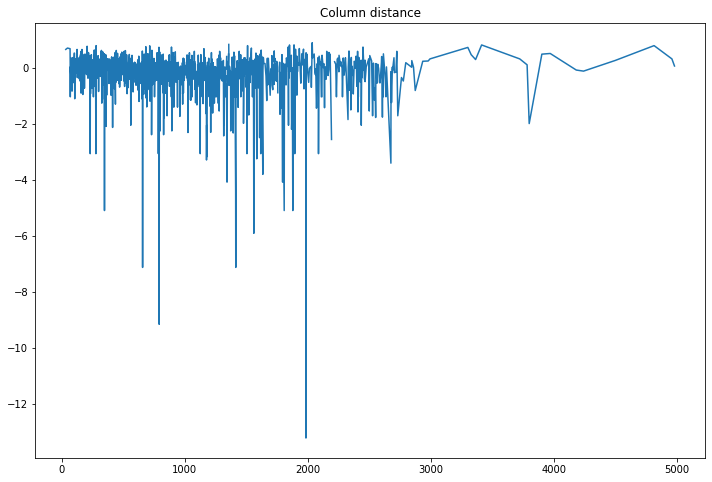

In [ ]:
compare_classifications_by_col('distance')

It's strange that some distance are way off.

So it looks like there were a few areas where there is a noticeable difference between the correctly classified and misclassified samples.

## Ensembling <a id="ensemble"></a>

One way to deal with this is through what is called "model ensembling". **Model ensembling** means training multiple models, and then having them "vote" on the correct answer. So for example, if we trained three models, then if two of them predicted the flight would be delayed and one didn't, we would go with the majority vote of it being delayed. This can be done a few different ways. One way is just to train multiple models on all of the data. Another is to train one or two models on the entire data, and then train the remaining model(s) on just the samples that were misclassified. That is the approach we'll take here. We will train a nearest neighbors classifier on the samples that were misclassified. We'll then train a slightly shallower decision tree on the misclassified data to use as our third vote. This is a decent approach because a shallower tree should look for more "big picture" ideas, rather than forming ultra-specific rules over 200+ levels.

In [ ]:
nn_clf = KNeighborsClassifier(n_neighbors=5, metric='hamming')

nn_clf.fit(X_train_all, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='hamming',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
dt2_clf = DecisionTreeClassifier()

hyperparam_grid = {'min_samples_split': [150, 200, 250],
                  'max_depth': [20, 30, 40, 50, 60],
                  'min_samples_leaf': [5, 7, 9]}

grid_search2 = GridSearchCV(dt2_clf, hyperparam_grid, n_jobs=-1)

grid_search2.fit(X_train_all, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40, 50, 60],
                 

In [ ]:
grid_search2.best_params_

{'max_depth': 20, 'min_samples_leaf': 9, 'min_samples_split': 200}

Now we want to make our models "vote". We'll write a function to find the most common vote (the "mode") and return it. Note that `mode` is imported from the `scipy` library at the top of the notebook, it is *not* a built-in Python function.

In [ ]:
def ensembled_model(model1, model2, model3, X):
    y1_pred = model1.predict(X)
    y2_pred = model2.predict(X)
    y3_pred = model3.predict(X)
    
    return mode([y1_pred, y2_pred, y3_pred]).mode[0]

In [ ]:
voting_results = ensembled_model(grid_search, nn_clf, grid_search2, X_test_all)

In [ ]:
voting_results

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
acc = sum(y_test == voting_results) / len(voting_results)
print(f'An overall accuracy of {100*acc:.2f}%')

An overall accuracy of 83.06%


In [ ]:
confusion_matrix(y_test, voting_results, normalize='true')

array([[0.95555543, 0.04444457],
       [0.71643422, 0.28356578]])

So we're doing very well predicting flights that will not be delayed (95%!), but still struggling on flights that will be delayed. Ensembling by hand like this is a slow, laborious process. Next week we will learn about models that have ensembling built into them, and and more efficient. However, ensembling by hand is still extremely popular, and almost all models that win data science competitions are ensembles.